In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import pandas as pd
import pickle
import random
import tensorflow as tf
import os
import sys
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde, norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from vae.vae import SVAE
from vae.train import train,train_new
from utils.data_processing import prep_data, make_tf_batches, seq_to_onehot
from vae.predict import predict
from utils.utils_f4f import heatmap, si_format
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'


#### Data_preparetion


In [13]:
# Import data 
target_assay = 'transduction'  # nor_package
array = 'seq'    #  RNA


df_all = pd.read_csv('../data/2nd_seq_aa_transduction.tsv',delimiter='\t')
df_all = df_all.rename(columns={'aa':'AA_sequence'})
df = df_all[[array, target_assay]]
df= df.sort_values(by=target_assay)

#Fill in the nan data and replace the inf value
df[target_assay] = df[target_assay].fillna(0)  
df[target_assay] = df[target_assay].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=[target_assay,array])
# df = df.iloc[::20]
df

,seq,transduction
2555,AGGAATCGGGATTCTCATGAT,-11.920341
2554,GGTAGGAGTACGGGGGTGGTG,-11.811235
2553,AGGATGGTGAATACGAATGTT,-11.808872
2552,ACGCATTCTAAGTCTGGTGGG,-11.796203
2551,AGTGGGAAGCCTAGTGTTAGT,-11.778599
...,...,...
4,TCTTCGCATATTTTTGGTGTT,5.748775
3,GGTGTGTGTTTTTTGCTTTAT,6.276683
2,CCGCAGAAGTGGCGGATTTAT,6.661751
1,CGGGCGGCTACTCATCATAGT,6.743405


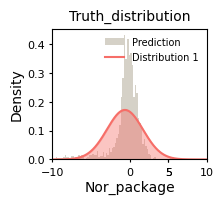

In [14]:
nor_package = df_all[np.isfinite(df_all[target_assay])][target_assay]
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 10, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Truth_distribution',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xlim([-9,9])
ax.set_xticks([-10,5,0,5,10]); 

plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
plt.show()

#### Prep data and make Tensorflow-compatible data batches

`prep_data()` will one-hot encode the `AA_sequence` column and split the data into
training and test sets. The training split will be split
futher into training and validation batches with `make_tf_batches()`.


In [15]:
(data_list, train_df, test_df, prepped_df) = prep_data(df, AA_colname=array,target_assay_col=target_assay)
train_df['Y--transduction'] = train_df['seq'].map(df.drop_duplicates('seq').set_index('seq')[target_assay])
test_df['Y--transduction'] = test_df['seq'].map(df.drop_duplicates('seq').set_index('seq')[target_assay])
prepped_df['Y--transduction'] = test_df['seq'].map(df.drop_duplicates('seq').set_index('seq')[target_assay])

In [16]:
train_df

,seq,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x411,x412,x413,x414,x415,x416,x417,x418,x419,Y--transduction
0,AGGAATCGGGATTCTCATGAT,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,-11.920341
1,GGTAGGAGTACGGGGGTGGTG,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,-11.811235
2,AGGATGGTGAATACGAATGTT,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,-11.808872
3,ACGCATTCTAAGTCTGGTGGG,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-11.796203
4,AGTGGGAAGCCTAGTGTTAGT,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,-11.778599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2296,CCGGCTTCGAGTGGGCGGTCT,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,5.367261
2297,TCTTCGCATATTTTTGGTGTT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,5.748775
2298,GGTGTGTGTTTTTTGCTTTAT,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,6.276683
2299,CCGCAGAAGTGGCGGATTTAT,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,6.661751


Now we split `train_df` into TensorFlow-compatible training and validation batches using
`make_tf_batches()`. `unbatched_data` is a tuple of Numpy arrays corresponding to the X, Y
and CV (if using) values across both the training and validation batches.


In [17]:
X, Y = data_list
train_batches, val_batches, unbatched_data = make_tf_batches(X, Y)

#### VAE training

Default parameterization (used in paper):

- `input_dim = 140`
- `latent_dim = 2`
- `enc_hidden_dims = [100,40]`
- `dec_hidden_dims = [40,100]`
- `reg_hidden_dims = [100,10]`


In [18]:
# SVAE parameters (same as default)
input_dim = 420
latent_dim = 2
enc_hidden_dims = [300,120]
dec_hidden_dims = [120,300]
reg_hidden_dims = [300,30]

# training parameters 
loss_weights = [1.0,0.8,1.5] # [reconstruction, KL, regression]

initial_learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

outpath = 'pretrain/vae/2nd_seq_nor_transduction'

initial_learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

# Initialize SVAE model (with default parameterizations)
model = SVAE(input_dim=420, latent_dim=6, enc_hidden_dims=[300,120], dec_hidden_dims=[120,300], reg_hidden_dims=[300,30], name='svae')
model.summary()

Model: "svae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 420)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 6),                  163872    ['encoder_input[0][0]',       
                              (None, 6),                             'encoder_input[0][0]']       
                              (None, 6)]                                                          
                                                                                                  
 tf.concat_3 (TFOpLambda)    (None, 426)                  0         ['encoder[1][0]',             
                                                                     'encoder_input[0][0]']    

The `train()` function returns the trained `model` and `preds_df`, a DataFrame of
regressor predictions on the X values in `unbatched_data`, along with their latent space
projections and their true Y values.

`train()` saves the trained model, as well as a log of the training and validation loss
values per epoch and `preds_df`, to disk. These saves will be made to an optional
parameter `model_outdir` - if not specified, `train()` will make a new,
informatively-named directory to write to (path is returned).

In [19]:
# Train model
model, preds_df, model_outdir = train_new(model, train_batches, val_batches, array,outpath,train_df, 
                        optimizer=optimizer,
                        loss_weights=loss_weights           
                        )


Logging following metrics: ['train_model_loss', 'train_reconstruction_loss', 'train_kl_loss', 'train_regression_loss', 'val_model_loss', 'val_reconstruction_loss', 'val_kl_loss', 'val_regression_loss']


----- Beginning training. -----

epoch 1
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 36.2548 - train_reconstruction_loss: 27.2233 - train_kl_loss: 0.4594 - train_regression_loss: 5.7777 - val_model_loss: 31.3752 - val_reconstruction_loss: 23.3113 - val_kl_loss: 0.1968 - val_regression_loss: 5.2710


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 2
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 31.4185 - train_reconstruction_loss: 23.1666 - train_kl_loss: 0.1713 - train_regression_loss: 5.4054 - val_model_loss: 30.3221 - val_reconstruction_loss: 22.9968 - val_kl_loss: 0.1728 - val_regression_loss: 4.7914


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 3
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 31.0891 - train_reconstruction_loss: 22.7801 - train_kl_loss: 0.1911 - train_regression_loss: 5.4357 - val_model_loss: 31.6683 - val_reconstruction_loss: 22.6543 - val_kl_loss: 0.2082 - val_regression_loss: 5.8983


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 4
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 30.6898 - train_reconstruction_loss: 22.4791 - train_kl_loss: 0.2422 - train_regression_loss: 5.3420 - val_model_loss: 31.7009 - val_reconstruction_loss: 22.4628 - val_kl_loss: 0.2381 - val_regression_loss: 6.0317


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 5
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 30.4712 - train_reconstruction_loss: 22.3328 - train_kl_loss: 0.2595 - train_regression_loss: 5.2800 - val_model_loss: 29.0565 - val_reconstruction_loss: 22.2097 - val_kl_loss: 0.2588 - val_regression_loss: 4.4265


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 6
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 30.2343 - train_reconstruction_loss: 22.0355 - train_kl_loss: 0.2988 - train_regression_loss: 5.3064 - val_model_loss: 28.8325 - val_reconstruction_loss: 21.6725 - val_kl_loss: 0.3217 - val_regression_loss: 4.6017


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 7
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 29.9574 - train_reconstruction_loss: 21.7724 - train_kl_loss: 0.3319 - train_regression_loss: 5.2802 - val_model_loss: 29.4472 - val_reconstruction_loss: 22.1197 - val_kl_loss: 0.3076 - val_regression_loss: 4.7210


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 8
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 29.2963 - train_reconstruction_loss: 21.7329 - train_kl_loss: 0.3438 - train_regression_loss: 4.8676 - val_model_loss: 30.7633 - val_reconstruction_loss: 21.6309 - val_kl_loss: 0.3322 - val_regression_loss: 5.9111


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 9
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 30.0217 - train_reconstruction_loss: 21.6668 - train_kl_loss: 0.3403 - train_regression_loss: 5.3969 - val_model_loss: 30.2306 - val_reconstruction_loss: 21.4651 - val_kl_loss: 0.3495 - val_regression_loss: 5.6573


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 10
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 29.6238 - train_reconstruction_loss: 21.6364 - train_kl_loss: 0.3495 - train_regression_loss: 5.1400 - val_model_loss: 30.4103 - val_reconstruction_loss: 21.3902 - val_kl_loss: 0.3452 - val_regression_loss: 5.8293


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 11
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 29.3774 - train_reconstruction_loss: 21.6365 - train_kl_loss: 0.3456 - train_regression_loss: 4.9719 - val_model_loss: 29.6596 - val_reconstruction_loss: 21.3377 - val_kl_loss: 0.3555 - val_regression_loss: 5.3584


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 12
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 29.6057 - train_reconstruction_loss: 21.6445 - train_kl_loss: 0.3409 - train_regression_loss: 5.1255 - val_model_loss: 30.0431 - val_reconstruction_loss: 21.7622 - val_kl_loss: 0.3297 - val_regression_loss: 5.3447


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 13
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 29.5235 - train_reconstruction_loss: 21.5166 - train_kl_loss: 0.3533 - train_regression_loss: 5.1448 - val_model_loss: 27.2485 - val_reconstruction_loss: 21.3255 - val_kl_loss: 0.3562 - val_regression_loss: 3.7587


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 14
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 28.5588 - train_reconstruction_loss: 21.3485 - train_kl_loss: 0.3788 - train_regression_loss: 4.6026 - val_model_loss: 28.6034 - val_reconstruction_loss: 21.4157 - val_kl_loss: 0.3678 - val_regression_loss: 4.5957


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 15
1036/1036 [==============================] - 13s 12ms/step - train_model_loss: 29.7045 - train_reconstruction_loss: 21.5365 - train_kl_loss: 0.3592 - train_regression_loss: 5.2559 - val_model_loss: 28.7922 - val_reconstruction_loss: 21.5432 - val_kl_loss: 0.3370 - val_regression_loss: 4.6529


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 16
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 29.3792 - train_reconstruction_loss: 21.3928 - train_kl_loss: 0.3764 - train_regression_loss: 5.1225 - val_model_loss: 27.8475 - val_reconstruction_loss: 21.2478 - val_kl_loss: 0.3880 - val_regression_loss: 4.1929


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 17
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 29.1895 - train_reconstruction_loss: 21.4255 - train_kl_loss: 0.3725 - train_regression_loss: 4.9708 - val_model_loss: 28.4397 - val_reconstruction_loss: 21.2115 - val_kl_loss: 0.3676 - val_regression_loss: 4.6228


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 18
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 29.2502 - train_reconstruction_loss: 21.2620 - train_kl_loss: 0.3795 - train_regression_loss: 5.1187 - val_model_loss: 28.0559 - val_reconstruction_loss: 21.2621 - val_kl_loss: 0.3878 - val_regression_loss: 4.3223


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 19
1036/1036 [==============================] - 13s 13ms/step - train_model_loss: 29.2401 - train_reconstruction_loss: 21.2936 - train_kl_loss: 0.3841 - train_regression_loss: 5.0874 - val_model_loss: 29.0804 - val_reconstruction_loss: 21.4693 - val_kl_loss: 0.3610 - val_regression_loss: 4.8815


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 20
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 28.7664 - train_reconstruction_loss: 21.2957 - train_kl_loss: 0.3876 - train_regression_loss: 4.7720 - val_model_loss: 28.2667 - val_reconstruction_loss: 20.9490 - val_kl_loss: 0.3964 - val_regression_loss: 4.6670


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 21
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 28.8783 - train_reconstruction_loss: 21.1771 - train_kl_loss: 0.3951 - train_regression_loss: 4.9254 - val_model_loss: 27.8334 - val_reconstruction_loss: 20.9042 - val_kl_loss: 0.4168 - val_regression_loss: 4.3971


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 22
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 28.6844 - train_reconstruction_loss: 21.1124 - train_kl_loss: 0.4127 - train_regression_loss: 4.8323 - val_model_loss: 29.2910 - val_reconstruction_loss: 21.1360 - val_kl_loss: 0.4188 - val_regression_loss: 5.2133


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 23
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 28.2864 - train_reconstruction_loss: 21.0839 - train_kl_loss: 0.4132 - train_regression_loss: 4.5915 - val_model_loss: 27.1576 - val_reconstruction_loss: 21.1525 - val_kl_loss: 0.3909 - val_regression_loss: 3.7949


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 24
1036/1036 [==============================] - 13s 12ms/step - train_model_loss: 28.8201 - train_reconstruction_loss: 21.1520 - train_kl_loss: 0.4038 - train_regression_loss: 4.8984 - val_model_loss: 28.5196 - val_reconstruction_loss: 21.2620 - val_kl_loss: 0.3705 - val_regression_loss: 4.6408


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 25
1036/1036 [==============================] - 13s 12ms/step - train_model_loss: 28.2420 - train_reconstruction_loss: 21.1640 - train_kl_loss: 0.4100 - train_regression_loss: 4.4949 - val_model_loss: 28.4618 - val_reconstruction_loss: 20.8095 - val_kl_loss: 0.4428 - val_regression_loss: 4.8654


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 26
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 28.3527 - train_reconstruction_loss: 21.0709 - train_kl_loss: 0.4096 - train_regression_loss: 4.6322 - val_model_loss: 27.9411 - val_reconstruction_loss: 20.9111 - val_kl_loss: 0.4342 - val_regression_loss: 4.4551


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 27
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 28.3168 - train_reconstruction_loss: 21.0509 - train_kl_loss: 0.4197 - train_regression_loss: 4.6156 - val_model_loss: 27.6867 - val_reconstruction_loss: 20.8708 - val_kl_loss: 0.4451 - val_regression_loss: 4.3066


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 28
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 28.1678 - train_reconstruction_loss: 21.0668 - train_kl_loss: 0.4142 - train_regression_loss: 4.5123 - val_model_loss: 27.8013 - val_reconstruction_loss: 20.7840 - val_kl_loss: 0.4466 - val_regression_loss: 4.4400


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 29
1036/1036 [==============================] - 13s 12ms/step - train_model_loss: 28.2538 - train_reconstruction_loss: 20.9158 - train_kl_loss: 0.4279 - train_regression_loss: 4.6605 - val_model_loss: 27.5092 - val_reconstruction_loss: 20.8366 - val_kl_loss: 0.4247 - val_regression_loss: 4.2219


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.

epoch 30
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 28.3467 - train_reconstruction_loss: 21.0681 - train_kl_loss: 0.4133 - train_regression_loss: 4.6282 - val_model_loss: 27.8316 - val_reconstruction_loss: 21.0390 - val_kl_loss: 0.4095 - val_regression_loss: 4.3100


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.
Convergence history: [0]

epoch 31
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 28.2656 - train_reconstruction_loss: 20.9585 - train_kl_loss: 0.4247 - train_regression_loss: 4.6400 - val_model_loss: 28.3268 - val_reconstruction_loss: 20.6293 - val_kl_loss: 0.4792 - val_regression_loss: 4.8761


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.
Convergence history: [0, 0]

epoch 32
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 27.7182 - train_reconstruction_loss: 20.8258 - train_kl_loss: 0.4466 - train_regression_loss: 4.3538 - val_model_loss: 27.2349 - val_reconstruction_loss: 20.7415 - val_kl_loss: 0.4285 - val_regression_loss: 4.1004


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.
Convergence history: [0, 0, 0]

epoch 33
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 27.5456 - train_reconstruction_loss: 20.7584 - train_kl_loss: 0.4399 - train_regression_loss: 4.2874 - val_model_loss: 27.5941 - val_reconstruction_loss: 20.7300 - val_kl_loss: 0.4591 - val_regression_loss: 4.3312


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.
Convergence history: [0, 0, 0, 1]

epoch 34
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 28.1106 - train_reconstruction_loss: 20.8647 - train_kl_loss: 0.4455 - train_regression_loss: 4.5881 - val_model_loss: 28.5749 - val_reconstruction_loss: 20.6960 - val_kl_loss: 0.4626 - val_regression_loss: 5.0058


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.
Convergence history: [0, 0, 0, 1, 0]

epoch 35
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 27.3003 - train_reconstruction_loss: 20.6981 - train_kl_loss: 0.4586 - train_regression_loss: 4.1564 - val_model_loss: 28.6904 - val_reconstruction_loss: 20.5542 - val_kl_loss: 0.4634 - val_regression_loss: 5.1770


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.
Convergence history: [0, 0, 0, 1, 0, 0]

epoch 36
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 27.7926 - train_reconstruction_loss: 20.7444 - train_kl_loss: 0.4595 - train_regression_loss: 4.4502 - val_model_loss: 27.3515 - val_reconstruction_loss: 20.3363 - val_kl_loss: 0.4856 - val_regression_loss: 4.4178


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.
Convergence history: [0, 0, 0, 1, 0, 0, 0]

epoch 37
1036/1036 [==============================] - 13s 12ms/step - train_model_loss: 27.3557 - train_reconstruction_loss: 20.7071 - train_kl_loss: 0.4658 - train_regression_loss: 4.1781 - val_model_loss: 26.8641 - val_reconstruction_loss: 20.5789 - val_kl_loss: 0.4731 - val_regression_loss: 3.9378


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.
Convergence history: [0, 0, 0, 1, 0, 0, 0, 0]

epoch 38
1036/1036 [==============================] - 13s 12ms/step - train_model_loss: 27.2533 - train_reconstruction_loss: 20.6164 - train_kl_loss: 0.4781 - train_regression_loss: 4.1796 - val_model_loss: 27.8243 - val_reconstruction_loss: 20.7016 - val_kl_loss: 0.4739 - val_regression_loss: 4.4957


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.
Convergence history: [0, 0, 0, 1, 0, 0, 0, 0, 0]

epoch 39
1036/1036 [==============================] - 13s 12ms/step - train_model_loss: 27.4929 - train_reconstruction_loss: 20.6755 - train_kl_loss: 0.4753 - train_regression_loss: 4.2974 - val_model_loss: 26.6513 - val_reconstruction_loss: 20.5259 - val_kl_loss: 0.4920 - val_regression_loss: 3.8211


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.
Convergence history: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

epoch 40
1036/1036 [==============================] - 12s 12ms/step - train_model_loss: 27.1498 - train_reconstruction_loss: 20.7149 - train_kl_loss: 0.4747 - train_regression_loss: 4.0309 - val_model_loss: 26.8981 - val_reconstruction_loss: 20.5286 - val_kl_loss: 0.4531 - val_regression_loss: 4.0047


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_seq_nor_transduction\assets


Model saved to pretrain/vae/2nd_seq_nor_transduction.
Hit maximum epochs.
Finished training model. Final overall losses:
train: 27.150    val:26.898
72/72 [==============================] - 0s 694us/step

MSE of predictions vs true labels: 4.2723236083984375


INFO:tensorflow:Assets written to: e:\Elite\Now_repority\20240220\trained_models\2024420_transduction_6D_40epochs_27.15T_26.90V\model\assets


INFO:tensorflow:Assets written to: e:\Elite\Now_repority\20240220\trained_models\2024420_transduction_6D_40epochs_27.15T_26.90V\model\assets


Model saved to e:\Elite\Now_repority\20240220\trained_models\2024420_transduction_6D_40epochs_27.15T_26.90V\model.
Losses saved to e:\Elite\Now_repority\20240220\trained_models\2024420_transduction_6D_40epochs_27.15T_26.90V\loss_log.csv.
Train predictions saved to e:\Elite\Now_repority\20240220\trained_models\2024420_transduction_6D_40epochs_27.15T_26.90V\preds.csv.


####  Correlation between result and prediction 

d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


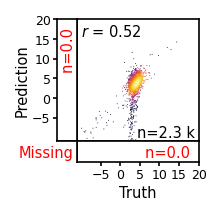

In [20]:
x = preds_df['y_pred']
y = preds_df['y_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=10, random_state=1), 
    y_both.sample(n=10, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))


fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.2f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)


# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/vae/2nd_results/nor_transduction/2nd_vae_seq_nor_transduction_correlation_train.pdf',dpi=300,bbox_inches='tight')

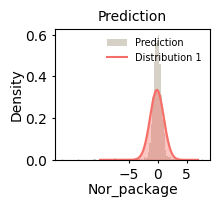

In [21]:
data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10,7, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
plt.show()
fig.savefig('../results/vae/2nd_results/nor_transduction/2nd_vae_seq_nor_transduction_distribution_train.pdf',dpi=300,bbox_inches='tight')

In [22]:
AA = test_df[array].values
X = test_df.drop(columns=['seq','Y--transduction'])
Y = test_df['Y--transduction'].values
preds_df = predict(model, X,array,Y=Y, AA=AA)
preds_df['y_pred'].corr(preds_df['y_true'])

8/8 [==============================] - 0s 0s/step

MSE of predictions vs true labels: 3.348593235015869


0.4799839115852569

d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


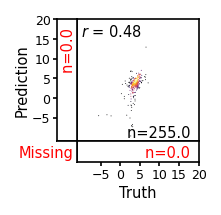

In [23]:
x = preds_df['y_pred']
y = preds_df['y_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=10, random_state=1), 
    y_both.sample(n=10, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))


fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.2f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)


# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/vae/2nd_results/nor_transduction/2nd_vae_seq_nor_transduction_correlation_test.pdf',dpi=300,bbox_inches='tight')

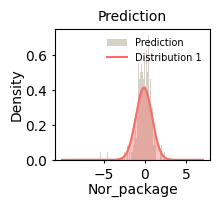

In [24]:

data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10,7, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
plt.show()
fig.savefig('../results/vae/2nd_results/nor_transduction/2nd_vae_seq_nor_transduction_distribution_test.pdf',dpi=300,bbox_inches='tight')
